In [1]:
import numpy as np
from numpy import array, float32

%matplotlib inline

In [2]:
import os
import sys

# Hacky fix to import from parent directory
path_to_this_notebook = os.path.abspath('../')
path_to_project = path_to_this_notebook[:path_to_this_notebook.find('note')]
sys.path.append(path_to_project)

In [3]:
from src.samplers.load_samplers import load_samplers
from src.environments.create_env import create_env
from src.optimization.heuristic_greedy import compute_greedy_heuristic
from src.optimization.deterministic_solution import compute_deterministic_solution

from src.utils.plot_results import plot_results

### Config and data loading

In [4]:
config = {'path_to_data': path_to_project + '/data/', 
          't0_hr': 6., # When the episode start (default value 6AM)
          'dt_min': 30, # Timestep size
          'ev_dt_min': 60, # Timestep size for EV arrivals
          'ev_sampling_dt_min': 60,  # How EV sessions are sampled from the data
          'apply_gaussian_noise': False, # Make data noisy
          'ev_utility_coef_mean': 1, # Mean value of the utility coefficient for the EVs
          'ev_utility_coef_scale': 0.13, # STD of the utility coefficient for the EVs
          'days_per_month_train': 20, # Days per month for training 
          'ev_session_months_train': ['01', 
        #   '02', '03', '04', '06', '07', '08', '09', '10', '11',
          ],
           # Months to sample EV sessions for training 
          'grid_to_use': 'ieee16', # What grid topology to use. Now supports only IEEE16. 
          'ev_session_months_test': ['05', '12'], # Months to sample EV sessions for test 
          'n_ps_pvs': 4, # Amount of solar panels that use PecanStreet data
          'n_canopy_pvs': 0, # Amount of solar panels that use canopy data
          'canopy_pv_rated_power': 250, # Rated power of these panels
          'n_loads': 0, # Amount of inflexible loads
          'n_feeders': 1, # Amount of feeders
          'n_ev_chargers': 4, # Amount of EV chargers
          
          'ps_pvs_rated_power': 4, # Rated power of these panels
          'avg_evs_per_day': 3.5, # Scaling of the EV arrival rate
          'feeder_p_min': -5, # Capacity of the feeders
          'g': 4, # Conductance of each line
          'i_max': 25, # Capacity of each line

          # New and improved config options
          'environment_type': 'gym', 
          'use_constraint_projection': False,
          'normalize_environment_outputs': True,
          'use_rescaled_actions': True,

          "violations_in_reward": False
          }

In [5]:
# Preload samplers, it is necessary to avoid re-loading data each time env is created
(ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
 price_sampler, price_metadata, ev_sampler, elaadnl_metadata) = load_samplers(config)

{'path_to_data': '/Users/fransdeboer/Projects/RL-EVCP//data/', 't0_hr': 6.0, 'dt_min': 30, 'ev_dt_min': 60, 'ev_sampling_dt_min': 60, 'apply_gaussian_noise': False, 'ev_utility_coef_mean': 1, 'ev_utility_coef_scale': 0.13, 'days_per_month_train': 20, 'ev_session_months_train': ['01'], 'grid_to_use': 'ieee16', 'ev_session_months_test': ['05', '12'], 'n_ps_pvs': 4, 'n_canopy_pvs': 0, 'canopy_pv_rated_power': 250, 'n_loads': 0, 'n_feeders': 1, 'n_ev_chargers': 4, 'ps_pvs_rated_power': 4, 'avg_evs_per_day': 3.5, 'feeder_p_min': -5, 'g': 4, 'i_max': 25, 'environment_type': 'gym', 'use_constraint_projection': False, 'normalize_environment_outputs': True, 'use_rescaled_actions': True, 'violations_in_reward': False}
loading ps meta data
loading ps solar data
loading arrivals data
loading price data
loading done
creating samplers
saving cache


In [6]:
# Create environment
env = create_env(config, ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
                 price_sampler, price_metadata, ev_sampler, elaadnl_metadata)

### Greedy

Reward = 315.39


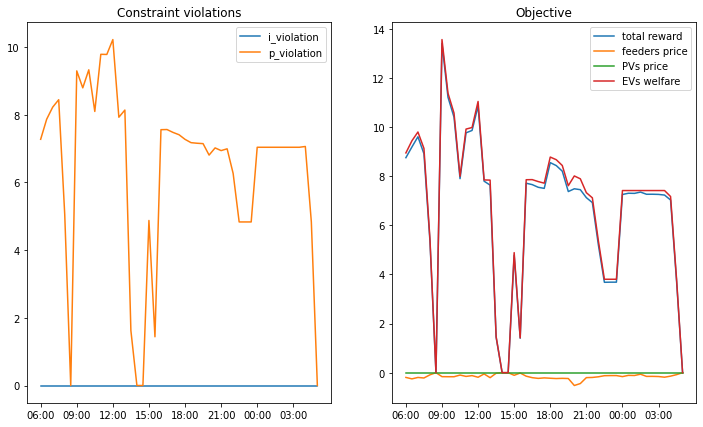

In [7]:
# Greedy heuristic which solves single-timestep OPF using lossless model
# It gets higher reward, but violates the power-flow constraints. 
env.use_rescaled_actions = False
env.normalize_outputs = False

np.random.seed(6)
env.reset(episode_index=6, train=True)

results_list = []
total_reward = 0

while not env.done:
    # print('t=%s' % env.t_str)

    state = env.compute_current_state()
    reshaped_state = state.reshape(-1, env.n_devices)
    p_lbs_t, p_ubs_t, v_lbs_t, v_ubs_t, u_t = reshaped_state[0], reshaped_state[1], reshaped_state[2], reshaped_state[3], reshaped_state[4]
    p, v, model = compute_greedy_heuristic(u_t, p_lbs_t, p_ubs_t, v_lbs_t, v_ubs_t, 
                                           env.conductance_matrix, env.i_max_matrix, 
                                           lossless=True, tee=False)
    action = np.concatenate((p,v), axis=0)
    _, _, _, result = env.step(action)
    total_reward += result['reward']
    results_list.append(result)
    
print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))



### Deterministic

Reward = 324.75


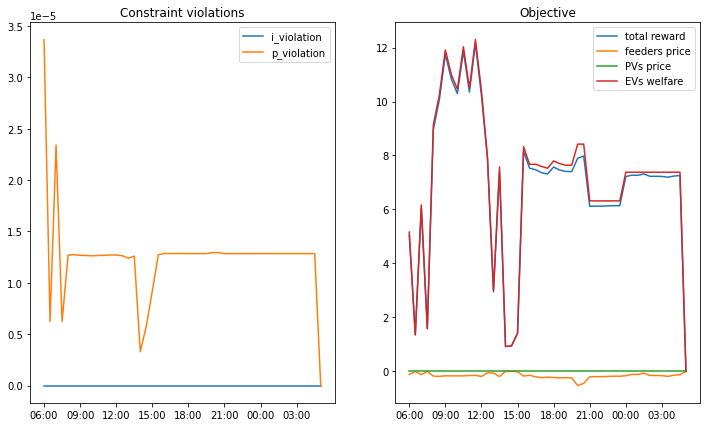

In [8]:
np.random.seed(6)
env.reset(episode_index=6, train=True)

p_lbs, p_ubs, v_lbs, v_ubs, u, evs_dict = env.compute_full_state()
p_det, v_det, model = compute_deterministic_solution(env.dt_min, evs_dict, u[0], p_lbs[0], 
                                                     p_ubs[0], v_lbs[0], v_ubs[0], 
                                                     env.conductance_matrix, env.i_max_matrix,
                                                     lossless=False, tee=False)
                                                     
results_list = []
total_reward = 0

while not env.done:
    action = np.concatenate((p_det[env.t_ind], v_det[env.t_ind]), axis=0)
    _, _, _, result = env.step(action)

    total_reward += result['reward']
    results_list.append(result)

print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))

### Optimal without constraints

Reward = 346.23
0 687.9200017929078


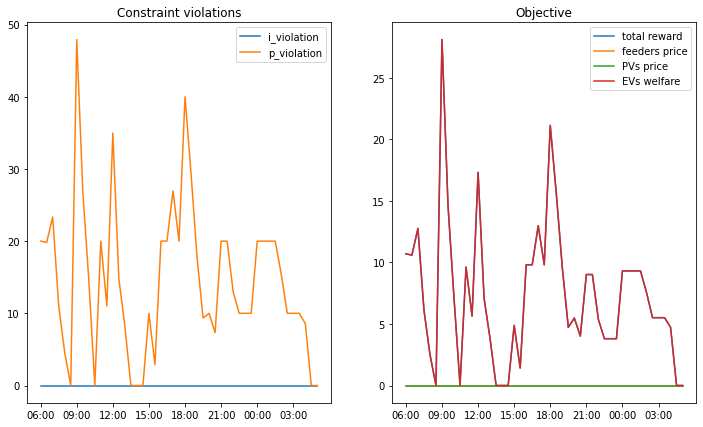

In [9]:
np.random.seed(6)
env.reset(episode_index=6, train=True)

results_list = []
total_reward = 0
i_violations = 0
p_violations = 0

while not env.done:
    state = env.compute_current_state()
    reshaped_state = state.reshape(-1, env.n_devices)
    p_lbs_t, p_ubs_t, v_lbs_t, v_ubs_t, u_t = reshaped_state[0], reshaped_state[1], reshaped_state[2], reshaped_state[3], reshaped_state[4]
    action = np.concatenate((p_ubs_t,v_ubs_t), axis=0)


    _, _, _, result = env.step(action)
    total_reward += result['reward']
    i_violations += result['i_constraints_violation']
    p_violations += result['power_flow_constraints_violation']
    results_list.append(result)
    
print('Reward = %.2f' % total_reward)
print(i_violations, p_violations)
plot_results(env, results_list, figsize=(12, 7))


In [12]:

actions = [array([-0.41328633, -0.22930504, -0.1966596 ,  0.12630782,  0.14490984,
        0.3893901 , -0.7566423 , -0.5506095 ,  0.5003474 , -0.27244118,
       -0.01295961,  0.48330098,  0.1095892 , -0.05414891, -0.35632363,
       -0.31110403,  0.30728558,  0.22809015,  0.39771512,  0.44593093,
        0.04841114, -0.46770892, -0.3143973 , -0.31499583,  0.5161841 ,
        0.04092632,  0.37440717, -0.19766721, -0.1547845 , -0.4226248 ,
        0.45719957,  0.66728663, -0.56168413, -0.26376647,  0.6171559 ,
        0.66330826,  0.08134531,  0.45751965,  0.52490366, -0.05430339,
       -0.482777  ,  0.15297358,  0.10061365,  0.210943  ], dtype=float32), array([-0.5024673 , -0.30726838, -0.34410608,  0.20388986,  0.45533782,
        0.5554021 , -0.5629557 , -0.681729  ,  0.5331982 , -0.40775788,
       -0.13909966,  0.7270339 ,  0.13821545, -0.13229701, -0.3188734 ,
       -0.5063039 ,  0.43541184,  0.3078956 ,  0.49926502,  0.8341832 ,
        0.07201499, -0.69788384, -0.4285532 , -0.762125  ,  0.38329703,
       -0.07409557,  0.3558445 , -0.30482316,  0.0270073 , -0.5142708 ,
        0.5639459 ,  0.49486607, -0.8169411 , -0.25777185,  0.6903609 ,
        0.652563  ,  0.01867649,  0.60389376,  0.75106   , -0.37174863,
       -0.62132883,  0.28435588,  0.1683718 ,  0.49651173], dtype=float32), array([-0.6230401 , -0.25913456, -0.36974257,  0.48870647,  0.54319763,
        0.3847766 , -0.8375105 , -0.6591761 ,  0.4898542 , -0.61468846,
       -0.21981654,  0.6788158 , -0.03380727, -0.16973647, -0.4450016 ,
       -0.43793198,  0.51969343,  0.30378565,  0.52131164,  0.87826663,
        0.00879437, -0.82583046, -0.6358042 , -0.5874899 ,  0.8180317 ,
        0.11938602,  0.60043156, -0.09841402, -0.01524998, -0.6515409 ,
        0.7014079 ,  0.72899246, -0.87538403, -0.5570615 ,  0.87364423,
        0.7965156 , -0.17540213,  0.5604522 ,  0.8956829 , -0.07169037,
       -0.61015964,  0.24466889,  0.34512442,  0.58720636], dtype=float32), array([-0.64185935, -0.34828532, -0.37346905,  0.37659085,  0.37105227,
        0.57914156, -0.95239246, -0.74992603,  0.68634   , -0.6326745 ,
       -0.24314763,  0.88041735,  0.12752956, -0.06829473, -0.53642696,
       -0.56333464,  0.30842578,  0.43176505,  0.69888014,  0.70629376,
       -0.05077909, -0.5868065 , -0.54949534, -0.5225746 ,  0.5734222 ,
        0.03229593,  0.46278998, -0.4360014 ,  0.00378466, -0.57829714,
        0.70772815,  0.8576489 , -0.9005569 , -0.38061875,  1.        ,
        0.8577841 , -0.22760504,  0.6823597 ,  0.9545925 , -0.23978786,
       -0.7671593 ,  0.32420397,  0.33550507,  0.67327696], dtype=float32), array([-0.71493864, -0.23514083, -0.22976673,  0.37840447,  0.49293244,
        0.5745501 , -0.83504856, -0.55340385,  0.7570414 , -0.554066  ,
       -0.20469522,  0.8620639 ,  0.00829066, -0.14208873, -0.58919275,
       -0.61520493,  0.2740866 ,  0.4105071 ,  0.810673  ,  0.6775731 ,
        0.11539565, -0.81539476, -0.62431985, -0.7646726 ,  0.79751754,
        0.14476013,  0.4431687 , -0.4608609 ,  0.03547391, -0.58097315,
        0.620038  ,  0.76585   , -1.        , -0.46776062,  1.        ,
        0.64926994, -0.2095528 ,  0.66017   ,  0.86121845, -0.19495323,
       -0.6459526 ,  0.39735755,  0.40832812,  0.51174796], dtype=float32), array([-0.7833411 , -0.40009734, -0.21804503,  0.42485797,  0.40230286,
        0.5679218 , -0.9476621 , -0.7166148 ,  0.5999801 , -0.46438605,
       -0.40856728,  0.91618055, -0.02399734, -0.01927845, -0.36150473,
       -0.48578978,  0.47516784,  0.31882572,  0.6190034 ,  0.57802427,
        0.13080302, -0.5897037 , -0.38622695, -0.6058176 ,  0.7867087 ,
        0.20759815,  0.52802163, -0.4464912 , -0.02324348, -0.6173284 ,
        0.78414035,  0.632662  , -0.78642213, -0.5757984 ,  1.        ,
        0.70237917, -0.05508175,  0.7463776 ,  0.71034503, -0.33673218,
       -0.7136162 ,  0.53757143,  0.22300601,  0.48092392], dtype=float32), array([-0.50869584, -0.31169555, -0.32049468,  0.3077518 ,  0.4559236 ,
        0.6069301 , -0.9284343 , -0.8157388 ,  0.7052781 , -0.5217745 ,
       -0.31315517,  0.8486742 ,  0.29007143, -0.27699807, -0.6444436 ,
       -0.5344768 ,  0.40589055,  0.3584775 ,  0.5760185 ,  0.6895396 ,
        0.14375082, -0.8697319 , -0.37642053, -0.551368  ,  0.7619434 ,
        0.1623595 ,  0.5780799 , -0.4702251 ,  0.1379763 , -0.76816374,
        0.63695693,  0.82874566, -0.9235103 , -0.45716515,  0.95745426,
        0.7136445 , -0.17884052,  0.5755524 ,  0.78146297, -0.24831681,
       -0.59217316,  0.4491863 ,  0.40469164,  0.7120326 ], dtype=float32), array([-0.87159836, -0.5240896 , -0.188287  ,  0.36640394,  0.748026  ,
        0.56447655, -0.9049108 , -0.7169519 ,  0.7334279 , -0.6027142 ,
       -0.21064423,  0.7707953 ,  0.18297471, -0.07995843, -0.42859766,
       -0.5418438 ,  0.49200687,  0.43871272,  0.8820609 ,  0.6427845 ,
        0.00165785, -0.81276524, -0.57329136, -0.7284623 ,  0.6223151 ,
        0.3401292 ,  0.65842384, -0.4220506 ,  0.00848532, -0.614254  ,
        0.64148444,  0.93079156, -0.896966  , -0.5056959 ,  0.71134496,
        0.66939604, -0.33172134,  0.6394924 ,  1.        , -0.29578322,
       -0.50316745,  0.26713723,  0.3016656 ,  0.7503937 ], dtype=float32), array([-0.58789957, -0.39109752, -0.22219217,  0.45075104,  0.43892047,
        0.6846961 , -0.7495108 , -0.77217734,  0.86044025, -0.61201453,
       -0.21885355,  0.8389095 ,  0.07580113, -0.18685788, -0.3196733 ,
       -0.57121885,  0.41846365,  0.36194053,  0.7038137 ,  0.97711354,
        0.02981384, -0.65497667, -0.397388  , -0.5982186 ,  0.6646256 ,
        0.2609308 ,  0.47037464, -0.1429808 , -0.08739075, -0.7258301 ,
        0.8286297 ,  0.8744396 , -0.75356174, -0.40743276,  0.7794289 ,
        0.8093518 , -0.13370138,  0.6630229 ,  1.        , -0.3146932 ,
       -0.74940586,  0.31529397,  0.2240535 ,  0.72335255], dtype=float32), array([-0.65582   , -0.19375077, -0.2881221 ,  0.23699264,  0.42819342,
        0.6604677 , -0.8372135 , -0.725935  ,  0.6431076 , -0.5954187 ,
       -0.2345519 ,  1.        , -0.05060968, -0.08568461, -0.4429651 ,
       -0.72107285,  0.59447944,  0.3475616 ,  0.64751244,  0.72342116,
        0.17972267, -0.77592397, -0.54921824, -0.5725855 ,  0.7664861 ,
        0.12524568,  0.5484176 , -0.38104632, -0.05379107, -0.6935431 ,
        0.688054  ,  0.70380616, -0.83551234, -0.68247074,  0.8083044 ,
        0.6109592 , -0.23286131,  0.5901467 ,  0.9076496 , -0.18004358,
       -0.73691213,  0.46969545,  0.36079356,  0.6832649 ], dtype=float32), array([-0.64489925, -0.35769314, -0.47363046,  0.35559487,  0.710574  ,
        0.5328133 , -0.9049823 , -0.87258935,  0.5398367 , -0.429409  ,
       -0.17297149,  0.909566  ,  0.08585873, -0.36680186, -0.50377023,
       -0.62710464,  0.4787152 ,  0.3057083 ,  0.7606715 ,  0.57571083,
       -0.11239859, -0.93106294, -0.368392  , -0.56416214,  0.82408255,
        0.13613191,  0.5614423 , -0.3081708 ,  0.10573683, -0.75186175,
        0.5534223 ,  0.72339106, -0.9159112 , -0.53234744,  1.        ,
        0.81099176, -0.35146496,  0.69820863,  0.9665584 , -0.20231393,
       -0.66284055,  0.24391432,  0.3436469 ,  0.54856014], dtype=float32), array([-0.7444708 , -0.377709  , -0.26150903,  0.35719743,  0.62601054,
        0.6857192 , -0.93797475, -0.7215427 ,  0.62064654, -0.61436397,
       -0.15887053,  0.9209323 , -0.00238432, -0.18305166, -0.566646  ,
       -0.5043189 ,  0.41743505,  0.28627276,  0.69369006,  0.87893355,
        0.20944686, -0.82699317, -0.54036605, -0.5856095 ,  0.74542725,
        0.21471786,  0.62640196, -0.24721956, -0.06603925, -0.7333033 ,
        0.7305043 ,  0.7515239 , -0.87080026, -0.58359426,  0.89990795,
        0.76129436, -0.14800404,  0.7133917 ,  0.7818106 , -0.20111436,
       -0.59674525,  0.5077883 ,  0.32849103,  0.679706  ], dtype=float32), array([-0.6855004 , -0.56552804, -0.20874304,  0.6365435 ,  0.4171933 ,
        0.6636578 , -0.8462162 , -0.7890389 ,  0.6519973 , -0.65530854,
       -0.2443136 ,  0.6912178 ,  0.1668025 , -0.05793765, -0.43929133,
       -0.4474525 ,  0.49921185,  0.3090055 ,  0.77247196,  0.6237974 ,
        0.11860954, -0.6619869 , -0.34978062, -0.6622593 ,  0.7284557 ,
        0.2570661 ,  0.57816124, -0.38093933, -0.07325225, -0.8454091 ,
        0.73999995,  0.92055315, -0.86249506, -0.4928868 ,  0.94430125,
        0.56596303, -0.217015  ,  0.56277394,  0.67139876, -0.21494076,
       -0.7192257 ,  0.4429528 ,  0.36797902,  0.57492036], dtype=float32), array([-0.6573706 , -0.33106124, -0.2835656 ,  0.48625425,  0.550089  ,
        0.5832338 , -0.8860723 , -0.7410871 ,  0.77104384, -0.4087076 ,
       -0.33463994,  0.77795905,  0.03943466, -0.26291516, -0.5452446 ,
       -0.7067335 ,  0.3986693 ,  0.35500607,  0.78170335,  0.8977186 ,
        0.06452803, -0.96270424, -0.5796297 , -0.8045039 ,  0.689239  ,
        0.23238118,  0.47374392, -0.41944006, -0.22086576, -0.4730227 ,
        0.93759686,  0.65471745, -0.7918648 , -0.41458777,  0.84536004,
        0.72573584, -0.16859369,  0.6878033 ,  0.8046263 , -0.26753426,
       -0.69598603,  0.23621337,  0.30939963,  0.6078624 ], dtype=float32), array([-0.7202907 , -0.49728793, -0.30644608,  0.43106568,  0.4561336 ,
        0.648577  , -0.95723224, -0.77602917,  0.6600472 , -0.6404536 ,
       -0.22516379,  0.7382488 ,  0.19535881, -0.20917016, -0.6709665 ,
       -0.7405838 ,  0.5713716 ,  0.2629387 ,  0.72405016,  0.7629549 ,
       -0.04402102, -0.69931114, -0.62847847, -0.6152105 ,  0.6967793 ,
        0.05573122,  0.44369355, -0.2958111 ,  0.06609251, -0.7185316 ,
        0.6742852 ,  0.8471504 , -0.8980009 , -0.54026455,  0.912951  ,
        0.7281246 , -0.1537911 ,  0.61915433,  0.8646138 , -0.19043845,
       -0.6602969 ,  0.30633754,  0.50053227,  0.8122688 ], dtype=float32), array([-0.75824654, -0.39113373, -0.22817847,  0.43424883,  0.6183314 ,
        0.59515923, -0.72576344, -0.95967776,  0.7322663 , -0.7417939 ,
       -0.06465895,  0.7395371 ,  0.23948413, -0.11866382, -0.6336045 ,
       -0.64162236,  0.47283733,  0.3838292 ,  0.660375  ,  0.9103167 ,
       -0.10405713, -0.5636812 , -0.6645457 , -0.5522024 ,  0.5811286 ,
        0.31595093,  0.62977684, -0.31391367, -0.00233558, -0.67907894,
        0.74118114,  0.7739641 , -0.7485667 , -0.4342561 ,  0.9913129 ,
        0.54332894, -0.09459742,  0.64168614,  0.8002623 , -0.2386283 ,
       -0.7096042 ,  0.30861437,  0.38956928,  0.8025013 ], dtype=float32), array([-0.69487715, -0.43395603, -0.4268006 ,  0.5168571 ,  0.6242659 ,
        0.6723105 , -0.7409844 , -0.79201615,  0.8109898 , -0.59388167,
       -0.21931192,  0.98874545,  0.16450107, -0.22150184, -0.5463806 ,
       -0.6472208 ,  0.64975655,  0.39294568,  0.48499924,  0.8747649 ,
       -0.09824785, -0.7233149 , -0.3966958 , -0.6212873 ,  0.7395724 ,
        0.06090423,  0.43048334, -0.49201405, -0.12992123, -0.63056815,
        0.6507746 ,  0.6996646 , -0.8618685 , -0.55725914,  0.86997235,
        0.805207  , -0.2643103 ,  0.68927443,  0.93214875, -0.15699199,
       -0.59302855,  0.43919417,  0.4045346 ,  0.5870547 ], dtype=float32), array([-0.64982927, -0.3103456 , -0.5137208 ,  0.34281194,  0.6188112 ,
        0.7188913 , -1.        , -0.74775493,  0.6882218 , -0.57964104,
       -0.34440595,  0.6660416 ,  0.1794191 , -0.15557635, -0.6596261 ,
       -0.626847  ,  0.34176707,  0.39657238,  0.6048802 ,  0.81520146,
       -0.06839628, -0.8412174 , -0.5421271 , -0.83625364,  0.88983655,
        0.19342712,  0.64646226, -0.43228555, -0.04670991, -0.8302362 ,
        0.8010788 ,  0.82906866, -0.78026235, -0.41912743,  0.85554636,
        0.7893776 , -0.15883574,  0.71781164,  1.        , -0.20957112,
       -0.6163149 ,  0.258719  ,  0.20959844,  0.49423984], dtype=float32), array([-0.61912477, -0.20950033, -0.51238084,  0.49270642,  0.47866085,
        0.5684695 , -1.        , -0.86190885,  0.66601914, -0.70408934,
       -0.40021813,  0.7200352 ,  0.21047732, -0.1703075 , -0.7110795 ,
       -0.6942508 ,  0.5399585 ,  0.4703262 ,  0.5852548 ,  0.8348036 ,
        0.1306954 , -0.7503357 , -0.38040352, -0.5834197 ,  0.58285403,
        0.05998436,  0.49219906, -0.4101534 ,  0.00757368, -0.6505119 ,
        0.5894457 ,  0.71495414, -0.8908866 , -0.58764756,  0.97271216,
        0.9133914 , -0.16769266,  0.6961909 ,  0.96894014, -0.4059727 ,
       -0.69435155,  0.5017005 ,  0.1880043 ,  0.49954274], dtype=float32), array([-0.60814005, -0.3021177 , -0.4866287 ,  0.5742297 ,  0.678129  ,
        0.8249121 , -0.91240346, -0.9668361 ,  0.7890378 , -0.5712373 ,
       -0.17941289,  0.8607505 ,  0.046139  , -0.16813946, -0.64738244,
       -0.61198986,  0.6183533 ,  0.48545545,  0.74413   ,  0.9217422 ,
        0.04505228, -0.7031129 , -0.49446392, -0.5227946 ,  0.6857562 ,
       -0.05783696,  0.47505945, -0.29318392,  0.09041455, -0.7630344 ,
        0.5907872 ,  0.82497245, -0.86637074, -0.49749386,  0.8979381 ,
        0.7234263 , -0.39661473,  0.58420956,  0.9547168 , -0.07959437,
       -0.6546898 ,  0.4631046 ,  0.27074224,  0.749635  ], dtype=float32), array([-0.5861081 , -0.33265406, -0.41029137,  0.49442023,  0.3747607 ,
        0.69604594, -0.9908631 , -0.7771723 ,  0.66098976, -0.5972504 ,
       -0.21409293,  0.82260424,  0.15961182, -0.0168194 , -0.4783875 ,
       -0.60068357,  0.48242348,  0.47315186,  0.6319324 ,  0.5723777 ,
        0.00171204, -0.83544976, -0.38655046, -0.8077905 ,  0.7715856 ,
        0.18792726,  0.63912743, -0.49044853,  0.05482806, -0.74587256,
        0.9041732 ,  0.7816144 , -0.85106987, -0.4627226 ,  0.8212375 ,
        0.782996  , -0.33509964,  0.6410135 ,  1.        , -0.19108348,
       -0.66275966,  0.35108703,  0.3861512 ,  0.5336786 ], dtype=float32), array([-0.5929282 , -0.27922374, -0.32520315,  0.48419017,  0.49627116,
        0.70064473, -0.7512564 , -0.8164107 ,  0.7739068 , -0.6765404 ,
       -0.16524526,  0.90172213,  0.02432349, -0.09454315, -0.52161646,
       -0.5707485 ,  0.5045009 ,  0.44253644,  0.68325514,  0.7067686 ,
        0.17306851, -0.7094778 , -0.37904444, -0.7169102 ,  0.58098626,
        0.16685754,  0.6185116 , -0.45090872,  0.06968622, -0.55480975,
        0.80215824,  0.6158215 , -0.8201641 , -0.5872153 ,  0.956233  ,
        0.86214364, -0.1531505 ,  0.66151386,  0.84334534, -0.22489128,
       -0.6389912 ,  0.25212923,  0.31634465,  0.4433645 ], dtype=float32), array([-0.5391338 , -0.22243199, -0.42938107,  0.48339334,  0.54487616,
        0.5732128 , -0.88918614, -0.79864115,  0.6291753 , -0.4396118 ,
       -0.15007694,  0.70479155,  0.07688589, -0.0911073 , -0.4324385 ,
       -0.579052  ,  0.6383462 ,  0.22667406,  0.61589056,  0.76011133,
        0.22858366, -0.6115932 , -0.4770653 , -0.5951108 ,  0.7974244 ,
        0.12307797,  0.56264555, -0.33041465, -0.07529866, -0.66301715,
        0.8183416 ,  0.8260054 , -0.9863411 , -0.6544938 ,  0.8206099 ,
        0.6870811 , -0.26905   ,  0.84802765,  0.7485481 , -0.24097867,
       -0.59986824,  0.2988736 ,  0.2616593 ,  0.5987392 ], dtype=float32), array([-0.5968335 , -0.34595364, -0.2019248 ,  0.39334232,  0.62187755,
        0.7637215 , -0.8346511 , -0.7180269 ,  0.50341356, -0.7784421 ,
       -0.4107923 ,  0.9805171 ,  0.23945238, -0.17569517, -0.391224  ,
       -0.7290798 ,  0.48450604,  0.4656593 ,  0.8813173 ,  0.82927537,
       -0.08548148, -0.77037215, -0.45354387, -0.59121805,  0.83427083,
        0.14680606,  0.5655493 , -0.35538274, -0.05601416, -0.86866826,
        0.7450559 ,  0.7767136 , -0.8646333 , -0.50693315,  0.962924  ,
        0.5983645 , -0.24427183,  0.6492571 ,  0.9723878 , -0.17091879,
       -0.6984274 ,  0.40116718,  0.5346468 ,  0.55362236], dtype=float32), array([-0.67355037, -0.26997122, -0.4660949 ,  0.4347413 ,  0.5970856 ,
        0.43908972, -0.98239017, -0.8200959 ,  0.61149114, -0.42870817,
       -0.13976866,  0.70063436,  0.01929986,  0.01505388, -0.38564277,
       -0.63668525,  0.4071957 ,  0.38583878,  0.73925436,  0.9304707 ,
       -0.04425409, -0.7847248 , -0.37914371, -0.7894677 ,  0.6351851 ,
        0.02573816,  0.73358643, -0.23050337, -0.22589286, -0.5514516 ,
        0.67861676,  0.5946468 , -0.8604532 , -0.43971616,  0.72776234,
        0.5867032 , -0.26168248,  0.6690993 ,  0.9067407 , -0.20521924,
       -0.6518448 ,  0.52143437,  0.33345145,  0.6293652 ], dtype=float32), array([-0.6717496 , -0.36447358, -0.32222196,  0.58314013,  0.60341305,
        0.6372183 , -0.9894209 , -0.70963734,  0.6494175 , -0.6310586 ,
       -0.2332878 ,  0.7368554 ,  0.19780858,  0.03296526, -0.49837217,
       -0.5575745 ,  0.66031444,  0.35285977,  0.52204376,  0.74810004,
        0.16787964, -0.7147151 , -0.5541291 , -0.77915263,  0.7863624 ,
        0.14279975,  0.6517324 , -0.24711196, -0.26223555, -0.79624426,
        0.8347308 ,  0.8405521 , -0.91787094, -0.6820563 ,  0.93454057,
        0.7726834 , -0.3179853 ,  0.76083237,  0.73257875, -0.29463133,
       -0.58220154,  0.38140488,  0.4145354 ,  0.5854351 ], dtype=float32), array([-0.6642217 , -0.2748645 , -0.43474972,  0.52073896,  0.5525902 ,
        0.51376706, -0.8367407 , -0.94400865,  0.6376446 , -0.67080337,
       -0.2072042 ,  0.9159188 ,  0.15956429, -0.08281108, -0.62837577,
       -0.8133474 ,  0.64771944,  0.2022282 ,  0.7277374 ,  0.69132787,
       -0.02304558, -0.76027846, -0.42984894, -0.70459276,  0.76355743,
        0.2769673 ,  0.49698177, -0.1867255 , -0.10568456, -0.67276466,
        0.69283843,  0.5464939 , -1.        , -0.3942762 ,  0.8207101 ,
        0.5417972 , -0.17185579,  0.51075196,  0.8829974 , -0.13446906,
       -0.75459594,  0.38609323,  0.4246532 ,  0.7232171 ], dtype=float32), array([-0.7433584 , -0.3572998 , -0.2165891 ,  0.47787955,  0.52170306,
        0.557612  , -0.9849011 , -0.811366  ,  0.7736602 , -0.42209873,
       -0.25134975,  0.6790583 ,  0.07336405, -0.10240692, -0.42044947,
       -0.7892395 ,  0.35345787,  0.4916571 ,  0.6692673 ,  0.76797175,
        0.07179637, -0.7336301 , -0.37577194, -0.821294  ,  0.6914296 ,
        0.08425241,  0.5674594 , -0.4123637 ,  0.07660365, -0.65055674,
        0.7570312 ,  0.9034037 , -0.7076035 , -0.38803184,  1.        ,
        0.74247444, -0.20655899,  0.52699655,  0.7851536 , -0.14369999,
       -0.62596476,  0.30702376,  0.45290595,  0.5656717 ], dtype=float32), array([-0.54786474, -0.39347395, -0.26678586,  0.46078372,  0.47059834,
        0.7833001 , -0.92750037, -0.76468784,  0.6006696 , -0.5456431 ,
       -0.23448701,  0.7712771 ,  0.02321371, -0.35254216, -0.51106834,
       -0.55374587,  0.5728158 ,  0.5789683 ,  0.88619846,  0.86265254,
        0.05843322, -0.85876626, -0.49310136, -0.9124544 ,  0.7044565 ,
       -0.04413785,  0.4864575 , -0.14545065,  0.01214435, -0.6102409 ,
        0.62100124,  0.76409256, -0.8838995 , -0.3749061 ,  0.79538417,
        0.7233214 , -0.22999264,  0.5743603 ,  0.8702008 , -0.41376263,
       -0.7815732 ,  0.5296412 ,  0.27408436,  0.52551174], dtype=float32), array([-0.67175907, -0.27843422, -0.42672187,  0.45425355,  0.74799174,
        0.7151139 , -0.92000645, -0.8239784 ,  0.76354796, -0.5594805 ,
       -0.15991104,  0.9848102 ,  0.13430816, -0.13558158, -0.42220196,
       -0.622915  ,  0.43502232,  0.267715  ,  0.64076406,  0.7511306 ,
        0.24328887, -0.89796686, -0.4940565 , -0.8826916 ,  0.68150914,
        0.19448726,  0.34544677, -0.36256525,  0.02340427, -0.5659489 ,
        0.937999  ,  0.7544027 , -0.84236413, -0.56637913,  1.        ,
        0.6962486 , -0.13082233,  0.47886664,  0.9188322 , -0.20097783,
       -0.7817893 ,  0.17901106,  0.2682648 ,  0.5837426 ], dtype=float32), array([-0.7456774 , -0.3448421 , -0.43182442,  0.4553587 ,  0.47159308,
        0.6924666 , -0.7910216 , -0.8165835 ,  0.6844564 , -0.504994  ,
       -0.365501  ,  0.8854041 ,  0.12016618, -0.05889222, -0.46346533,
       -0.6485578 ,  0.40682667,  0.429816  ,  0.51039314,  0.72179276,
        0.19045538, -0.856464  , -0.62651354, -0.75119036,  0.7210154 ,
        0.26392204,  0.5870892 , -0.34358042,  0.06441258, -0.7871941 ,
        0.89776635,  0.7185479 , -0.94325787, -0.53672814,  0.7893706 ,
        0.6440832 , -0.13411444,  0.6809439 ,  0.90337956, -0.29734212,
       -0.48773867,  0.26193762,  0.13764165,  0.41495675], dtype=float32), array([-0.5738702 , -0.33639976, -0.16379961,  0.561093  ,  0.59963906,
        0.7581086 , -0.88918424, -0.9076284 ,  0.5713111 , -0.6696967 ,
       -0.3168677 ,  0.7773561 ,  0.08240704, -0.29736638, -0.49329352,
       -0.60727555,  0.6191475 ,  0.39399895,  0.58696836,  0.9562977 ,
        0.14447854, -0.7850107 , -0.3700233 , -0.71426195,  0.75694233,
        0.08493635,  0.48290923, -0.38956457, -0.24274032, -0.6108345 ,
        0.71898067,  0.6161428 , -0.6542372 , -0.57745004,  0.8818236 ,
        0.6699595 , -0.19951154,  0.7599983 ,  0.87654674, -0.13389593,
       -0.7393844 ,  0.18348074,  0.38798547,  0.4867878 ], dtype=float32), array([-0.6100917 , -0.3226478 , -0.32768685,  0.31927148,  0.47851452,
        0.72663903, -0.7587717 , -0.6798515 ,  0.4602366 , -0.6815173 ,
       -0.3155126 ,  0.88563347, -0.00529599, -0.21603745, -0.47232348,
       -0.79718494,  0.38824454,  0.42179623,  0.6223537 ,  0.68114626,
        0.11632063, -0.8338891 , -0.5722368 , -0.6111574 ,  0.7150403 ,
        0.29091072,  0.49467832, -0.3338848 , -0.0526271 , -0.6908718 ,
        0.6056073 ,  0.76110244, -0.7851808 , -0.5742293 ,  0.7832751 ,
        0.7918833 , -0.32327503,  0.57140774,  0.8285419 , -0.27587655,
       -0.81488   ,  0.4513248 ,  0.29561293,  0.69990355], dtype=float32), array([-8.0738151e-01, -4.0694574e-01, -2.7928385e-01,  5.7503432e-01,
        7.4731535e-01,  6.2371987e-01, -9.0577954e-01, -8.5495830e-01,
        7.8187108e-01, -6.0690296e-01, -2.5550762e-01,  9.1982204e-01,
        9.7222850e-03, -5.8403619e-02, -4.9400952e-01, -4.7210720e-01,
        3.8939241e-01,  4.3187767e-01,  5.7872969e-01,  7.2621912e-01,
        1.5518595e-01, -8.0217433e-01, -4.0415305e-01, -6.9704384e-01,
        7.9754716e-01,  5.1168285e-02,  6.8399245e-01, -3.2298297e-01,
       -3.5937503e-04, -7.4983054e-01,  8.9473695e-01,  6.1897707e-01,
       -7.7516347e-01, -5.0521100e-01,  6.8668234e-01,  7.1633452e-01,
       -1.1315538e-01,  6.4920682e-01,  9.0176862e-01, -1.8454629e-01,
       -6.7232037e-01,  2.8627154e-01,  1.3746081e-01,  6.0494810e-01],
      dtype=float32), array([-0.5003464 , -0.2620621 , -0.1897285 ,  0.3160536 ,  0.51913536,
        0.59954834, -0.9189775 , -0.7609894 ,  0.5709365 , -0.63035   ,
       -0.23640974,  0.61295867,  0.20278698, -0.24517736, -0.5340467 ,
       -0.49832126,  0.52915204,  0.5298586 ,  0.62379503,  0.75197077,
       -0.11207454, -0.947756  , -0.44729564, -0.6823352 ,  0.6765679 ,
        0.03476366,  0.4266138 , -0.54242384, -0.01955487, -0.68728226,
        0.59591794,  0.8124281 , -0.6542042 , -0.47139546,  0.7735639 ,
        0.73681617, -0.28421792,  0.5531695 ,  0.8431278 , -0.22241043,
       -0.69165933,  0.34942093,  0.23637438,  0.45721728], dtype=float32), array([-0.67072886, -0.29125828, -0.11376511,  0.6075972 ,  0.68984836,
        0.53028715, -0.7859117 , -0.77946794,  0.62358016, -0.6747149 ,
       -0.19426686,  0.84899956,  0.0404337 , -0.3101237 , -0.4237838 ,
       -0.6499682 ,  0.3641232 ,  0.34175983,  0.76838857,  0.750063  ,
       -0.0583877 , -0.72402805, -0.52740175, -0.7615279 ,  0.6174119 ,
        0.33970028,  0.64354074, -0.29413676,  0.03902624, -0.8084199 ,
        0.7988433 ,  0.6760283 , -0.75477177, -0.66235983,  0.90207535,
        0.77182066, -0.27968577,  0.52912074,  0.98044   , -0.293478  ,
       -0.72427493,  0.3866101 ,  0.44556627,  0.76815397], dtype=float32), array([-0.4841122 , -0.39319226, -0.24827373,  0.49375558,  0.39411843,
        0.44223624, -0.8261486 , -0.8011763 ,  0.6845801 , -0.6124276 ,
       -0.2707358 ,  0.88672173,  0.24908155, -0.18861163, -0.5140419 ,
       -0.61997414,  0.60694444,  0.49779302,  0.75778645,  0.77415466,
        0.04261197, -0.96470493, -0.57681674, -0.80381846,  0.67490244,
        0.1114421 ,  0.5591898 , -0.50380903,  0.01022311, -0.60419136,
        0.8754879 ,  0.5865515 , -0.9745966 , -0.5185852 ,  0.9477077 ,
        0.76761127, -0.36873788,  0.71912885,  0.87078255, -0.10415246,
       -0.60326195,  0.27643493,  0.34953094,  0.7397241 ], dtype=float32), array([-0.8844911 , -0.24514498, -0.1504964 ,  0.37195414,  0.349568  ,
        0.5355292 , -0.88544774, -0.75392014,  0.67681783, -0.69675535,
       -0.0342858 ,  0.79416597,  0.3048313 , -0.21684657, -0.49549097,
       -0.41662163,  0.46687496,  0.52778566,  0.71256155,  0.86572164,
        0.01584356, -0.63043296, -0.45581087, -0.7334333 ,  0.66658664,
       -0.03320023,  0.34719092, -0.28786027,  0.02636101, -0.7343469 ,
        0.74122125,  0.83024895, -0.9126235 , -0.5065557 ,  0.8579942 ,
        0.84969413, -0.26828185,  0.6382668 ,  0.75932324, -0.21918358,
       -0.6635579 ,  0.32847968,  0.3280438 ,  0.61464524], dtype=float32), array([-0.70427984, -0.32354233, -0.3358912 ,  0.5123077 ,  0.41758817,
        0.83451414, -0.9857797 , -0.6187925 ,  0.6690479 , -0.6109304 ,
       -0.13416499,  1.        ,  0.12684497,  0.03197195, -0.57677615,
       -0.5500368 ,  0.3906964 ,  0.32379392,  0.691932  ,  0.6232386 ,
       -0.10013275, -0.77891666, -0.28458893, -0.7836522 ,  0.5233588 ,
        0.14829099,  0.57232124, -0.22411022, -0.11985441, -0.56326175,
        0.84469485,  0.747399  , -0.90487313, -0.6096226 ,  0.9389835 ,
        0.54464364, -0.3639869 ,  0.79048455,  0.7991215 , -0.27623078,
       -0.8297446 ,  0.31063473,  0.19443648,  0.660767  ], dtype=float32), array([-0.76425195, -0.5108653 , -0.21915367,  0.40788403,  0.55153716,
        0.63500965, -0.8552952 , -0.5725318 ,  0.4627353 , -0.5479141 ,
       -0.2355905 ,  0.80502284, -0.06809899, -0.13439165, -0.52222306,
       -0.6301437 ,  0.54394233,  0.38422343,  0.7873951 ,  0.8881666 ,
        0.03595156, -0.7547021 , -0.45850986, -0.6846452 ,  0.7047163 ,
       -0.04167253,  0.54594   , -0.37942928, -0.06177628, -0.5201755 ,
        0.6742489 ,  0.67242485, -0.8320185 , -0.5602361 ,  0.74794346,
        0.7850401 , -0.31344226,  0.65375304,  0.8318662 , -0.23336577,
       -0.7308981 ,  0.4930852 ,  0.16387604,  0.60104746], dtype=float32), array([-0.83814734, -0.3901902 , -0.24081928,  0.49415967,  0.5683058 ,
        0.71455073, -0.84703714, -0.58982354,  0.61601275, -0.6389729 ,
       -0.413659  ,  0.70817816,  0.12781328, -0.20736326, -0.5023646 ,
       -0.50971967,  0.5437571 ,  0.367052  ,  0.88248837,  0.8221804 ,
       -0.1120055 , -0.56534004, -0.5904068 , -0.81239647,  0.66697025,
        0.18857925,  0.7474314 , -0.35606033,  0.05085928, -0.6615354 ,
        0.68388295,  0.63125265, -0.88977545, -0.4969866 ,  0.8560425 ,
        0.80464476, -0.13905382,  0.6115329 ,  1.        , -0.24776751,
       -0.76506907,  0.2926602 ,  0.42404607,  0.58536476], dtype=float32), array([-0.70313036, -0.19655609, -0.3187951 ,  0.47707966,  0.6553835 ,
        0.6393064 , -0.9634253 , -0.701068  ,  0.7292376 , -0.5998714 ,
       -0.16061594,  0.6303079 ,  0.02503973, -0.17148043, -0.6458495 ,
       -0.6611295 ,  0.425756  ,  0.46953705,  0.81967086,  0.8147888 ,
       -0.00646874, -0.7844033 , -0.45105642, -0.76823056,  0.8414771 ,
        0.07679019,  0.6909168 , -0.19804013,  0.08913816, -0.75812954,
        0.78531426,  0.8061072 , -0.93685335, -0.50327075,  0.7851287 ,
        0.6527713 , -0.07658076,  0.7055088 ,  0.83673584, -0.05092835,
       -0.6913253 ,  0.43738374,  0.3373943 ,  0.6829337 ], dtype=float32), array([-0.7214308 , -0.42614233, -0.16362311,  0.23885389,  0.44347805,
        0.84296083, -0.84712994, -0.8097626 ,  0.67681694, -0.49003005,
       -0.12463   ,  0.77530473,  0.18802135, -0.31931186, -0.43421322,
       -0.6101439 ,  0.29302981,  0.5278381 ,  0.598117  ,  0.7906266 ,
        0.19676471, -0.71515673, -0.38956356, -0.64704907,  0.732995  ,
        0.16083226,  0.49363318, -0.48848563,  0.05803302, -0.51605177,
        0.7653012 ,  0.634903  , -1.        , -0.61136323,  0.9618111 ,
        0.81932926, -0.1945751 ,  0.7578998 ,  0.8242542 , -0.19389829,
       -0.65572435,  0.30076164,  0.23691869,  0.69153655], dtype=float32), array([-0.48622173, -0.20502143, -0.16107215,  0.37311488,  0.61750466,
        0.77692235, -0.8900671 , -0.7116708 ,  0.7516325 , -0.79272443,
       -0.41090953,  0.7849784 ,  0.06217641, -0.12105055, -0.5257296 ,
       -0.536872  ,  0.38489622,  0.33758926,  0.6197136 ,  0.79476964,
        0.14274064, -0.67618686, -0.57181525, -0.892548  ,  0.64961964,
        0.17897299,  0.3475455 , -0.41094032, -0.03151232, -0.61806667,
        0.8592621 ,  0.91568744, -0.93878686, -0.43304634,  0.83977693,
        0.69397426, -0.05034898,  0.81342244,  0.91201997, -0.06731354,
       -0.8388349 ,  0.37083262,  0.2048842 ,  0.6226101 ], dtype=float32), array([-0.70128876, -0.40632433, -0.20300579,  0.5881315 ,  0.58391863,
        0.5313795 , -1.        , -0.6728955 ,  0.58624125, -0.57031524,
       -0.23775314,  0.7776539 ,  0.27662647, -0.266563  , -0.343011  ,
       -0.6273605 ,  0.5496187 ,  0.4636079 ,  0.8180382 ,  0.71579134,
       -0.01766769, -0.5650226 , -0.3730254 , -0.668689  ,  0.78483987,
        0.1203199 ,  0.55822337, -0.4071366 , -0.13124263, -0.8176142 ,
        0.7919416 ,  0.7500799 , -0.8833907 , -0.48091036,  0.8144607 ,
        0.8591842 , -0.18728831,  0.60733587,  0.77582616, -0.20869394,
       -0.6412706 ,  0.18037347,  0.32890904,  0.6189525 ], dtype=float32), array([-0.8287326 , -0.5808755 , -0.43161404,  0.6271603 ,  0.59084773,
        0.46911412, -0.9260334 , -0.7960819 ,  0.48862687, -0.62532336,
       -0.16112651,  0.6153603 ,  0.23459163, -0.10687926, -0.45440602,
       -0.7889406 ,  0.4963217 ,  0.39537027,  0.53744006,  0.69037944,
        0.25718823, -0.67195106, -0.49142867, -0.7497616 ,  0.6138351 ,
        0.08638138,  0.5894538 , -0.14453773, -0.0578775 , -0.7923769 ,
        0.71693224,  0.85849726, -0.8699518 , -0.5953406 ,  0.8703196 ,
        0.70993406, -0.2357351 ,  0.6190599 ,  1.        , -0.15075746,
       -0.5449816 ,  0.5136043 ,  0.30317137,  0.564618  ], dtype=float32), array([-0.71094143, -0.41323286, -0.22090344,  0.2885027 ,  0.47899735,
        0.6087053 , -0.89610606, -0.8930786 ,  0.6366634 , -0.5069512 ,
       -0.24256267,  0.7192581 ,  0.15901344, -0.36702096, -0.36362624,
       -0.5609033 ,  0.5964252 ,  0.46765944,  0.63976616,  0.9552543 ,
        0.13148175, -0.7832091 , -0.50815034, -0.8343873 ,  0.7033605 ,
        0.10906281,  0.4113197 , -0.31431302,  0.10058215, -0.77030474,
        0.5703299 ,  0.6048868 , -0.8651117 , -0.49410522,  0.88282895,
        0.66473156, -0.15994422,  0.5744495 ,  0.68275076, -0.23667037,
       -0.73586214,  0.23690666,  0.32287133,  0.62642354], dtype=float32)]


47 47
Reward = 230.44
138720.21349668503 110395.50729295141


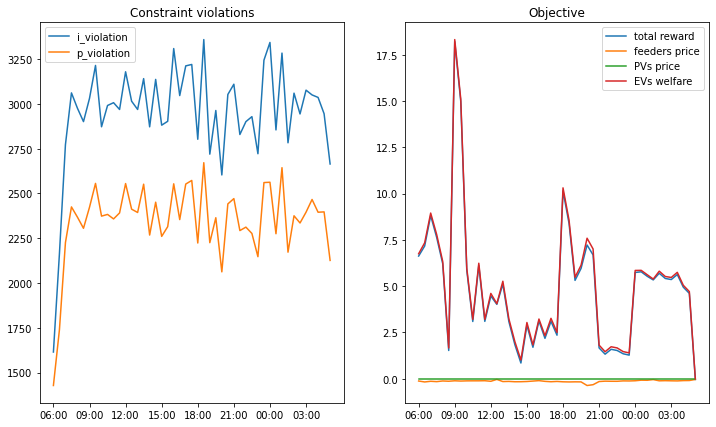

In [13]:
# Greedy heuristic which solves single-timestep OPF using lossless model
# It gets higher reward, but violates the power-flow constraints. 
env.use_rescaled_actions = True
env.normalize_outputs = True

np.random.seed(6)
env.reset(episode_index=6, train=True)

results_list = []
total_reward = 0
i_violations = 0
p_violations = 0

while not env.done:
    # print('t=%s' % env.t_str)
    action = actions[env.t_ind]
    _, _, _, result = env.step(action)
    total_reward += result['reward']
    i_violations += result['i_constraints_violation']
    p_violations += result['power_flow_constraints_violation']
    results_list.append(result)

print(env.t_ind, len(actions))
print('Reward = %.2f' % total_reward)
print(i_violations, p_violations)
plot_results(env, results_list, figsize=(12, 7))

The goal of the project is to come up with an RL based method that computes nodal powers and voltages that maximize the objective while keeping the constraint violations small.  The above simulations use the benchmarks that you should be comparing to. Clearly, you want to beat the greedy heuristic , but you can't beat the deterministic planner as it is the absolute optimal solution (assuming known future).